# Autonomous Vehicles Animal Detection

if you are running on colab, run the following cell

In [1]:
!git clone https://github.com/Giovannicus/AnimalRec.git
%cd /content/AnimalRec
%pwd

Cloning into 'AnimalRec'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 84 (delta 44), reused 44 (delta 15), pack-reused 0 (from 0)
Receiving objects: 100% (84/84), 756.50 KiB | 2.09 MiB/s, done.
Resolving deltas: 100% (44/44), done.
/content/AnimalRec


'/content/AnimalRec'

### Import libraries

In [2]:
import os
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.backend import clear_session
from tensorflow.keras.initializers import RandomNormal
import plotly.graph_objects as go

# Eda & Preprocessing

### Import data and convert to binary

In [4]:
from tensorflow.keras.datasets.cifar10 import load_data

(X_train, Y_train), (X_test, y_test) = load_data()

In [5]:
Y_train = (Y_train >= 2) & (Y_train < 8);
y_test = (y_test >= 2) & (y_test < 8);

### Pieplot target distribution

In [7]:
fig = go.Figure(data=[go.Pie(labels=["Animal", "Not animal"],
                             values=[np.mean(Y_train), 1 - np.mean(Y_train)],
                             hoverinfo="label+percent",  # Mostra etichetta, percentuale e valore
                             textinfo='percent',  # Mostra solo la percentuale sulle fette

                             pull=[0, 0.01],  # Evidenzia la seconda fetta
                             marker=dict(colors=['#FF0000', '#408040']),  # Colori personalizzati
                             textfont=dict(size=18)
                             )])


fig.update_layout(
    paper_bgcolor = "rgba(0,0,0,1)",
    plot_bgcolor = "rgba(0,0,0,1)",
    title={
        'text': "Target distribution",
        'font': {'color': 'white'}
    },
    font=dict(
        color='white',
        size=18
    ),
    legend=dict(
        font=dict(color='white')
    )
)

fig.show()

Distribution is fairly balanced

###Data augmentation

In [8]:
train_datagen = ImageDataGenerator(
    rescale = 1/255.,
    rotation_range=15,
    vertical_flip=True,
)

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# Model

## Transfer Learning

Use pre-trained vgg16 model freezing its conv layers

In [ ]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3),name="vgg16_mod")
for layer in vgg16.layers:
    layer.trainable = False
vgg16 = Model(inputs=vgg16.inputs, outputs=vgg16.layers[-2].output)
vgg16.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

add dense layers by yourself

In [ ]:
w_init = RandomNormal(stddev=0.01)
x = vgg16.output
x = Flatten() (x)
#x = Dropout(0.2) (x)
x = Dense(1024, activation='relu') (x)
x = Dense(256, activation='relu') (x)
x = Dense(64, activation='relu') (x)
x = Dense(16, activation='relu') (x)
x = Dropout(0.2) (x)
x = Dense(1, activation='sigmoid') (x)

In [ ]:
clear_session()
model = Model(inputs=vgg16.input, outputs=x,name="vgg16_mod")
model.summary()

Model: "vgg16_mod"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 17,092,769 (65.20 MB)

 Trainable params: 2,378,081 (9.07 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Training

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy', "precision"])
n_epochs = 20
hist = model.fit(train_datagen.flow(x_train, y_train, batch_size=32),
              epochs=n_epochs,
              validation_data=(train_datagen.flow(x_valid, y_valid)),
              callbacks=[early_stopping],
              verbose=1)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



1250/1250 ━━━━━━━━━━━━━━━━━━━━ 714s 565ms/step - accuracy: 0.8717 - loss: 0.3053 - precision: 0.8820 - val_accuracy: 0.8595 - val_loss: 0.3296 - val_precision: 0.9309
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 746s 569ms/step - accuracy: 0.8786 - loss: 0.2918 - precision: 0.8901 - val_accuracy: 0.8787 - val_loss: 0.2837 - val_precision: 0.8942
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 802s 617ms/step - accuracy: 0.8838 - loss: 0.2836 - precision: 0.8934 - val_accuracy: 0.8800 - val_loss: 0.2839 - val_precision: 0.9050
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 710s 568ms/step - accuracy: 0.8863 - loss: 0.2778 - precision: 0.8972 - val_accuracy: 0.8922 - val_loss: 0.2677 - val_precision: 0.9079
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 709s 567ms/step - accuracy: 0.8901 - loss: 0.2688 - precision: 0.9040 - val_accuracy: 0.8794 - val_loss: 0.2817 - val_precision: 0.9092
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 697s 558ms/step - accuracy: 0.8906 - loss: 0.2611 - precision: 0.9008 - val_acc

In [ ]:
import json
model.save("vgg16_mod.h5")
with open('training_history.json', 'w') as f:
    json.dump(hist.history, f)

In [ ]:
from keras.models import load_model
import json
model = load_model('vgg16_mod.h5')
with open('training_history.json', 'r') as f:
    hist = json.load(f)

# Results

In [ ]:
y_pred = model.predict(X_test/255.)

313/313 ━━━━━━━━━━━━━━━━━━━━ 130s 414ms/step


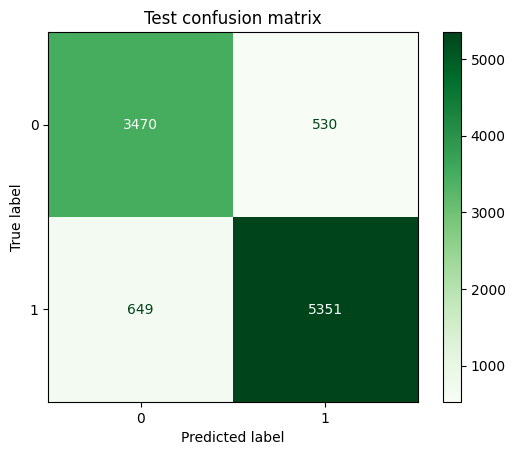

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test.astype(int), (y_pred>=.5).astype(int))

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Greens)
plt.title("Test confusion matrix")
plt.show()


In [19]:
from result import plot_result

try:
  plot_result(hist)
except:
  plot_result(hist.history)
